# Build a Fully-Connected Net on MNIST in PyTorch

February 2019

---

Useful links:
- [torch FC example](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html)


In [1]:
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import time
import copy

In [58]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [1]:
%%writefile rgutils/plot_utils.py

import matplotlib.pyplot as plt

def plot_learning_curve(history, fig_shape=(12,4), plot_style='fivethirtyeight'):
    '''
    Plots learning curve for loss and score both for train and validation
    -------
    :metrics is a dict with following keys: ['step', 'val_loss', 'loss', 'val_score', 'score'], where values are lists
    '''
    plt.style.use(plot_style)
    plt.figure(figsize=fig_shape)
    plt.subplot(121)
    plt.title('Loss curves')
    plt.plot(history['epoch'], history['train_loss'], 'r--', label='train loss')
    plt.plot(history['epoch'], history['val_loss'], 'b--', label='validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(122)
    plt.title('Score curves')
    plt.plot(history['epoch'], history['train_score'], 'r--', label='train score')
    plt.plot(history['epoch'], history['val_score'], 'b--', label='validation score')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Writing rgutils/plot_utils.py


In [2]:
%%writefile rgutils/torch_utils.py

def train_epoch(model, dataloader, device, optimizer, criterion):
    '''
    Makes 1 training epoch and evaluates train error
    '''
    model.train()
    
    running_loss = 0
    num_correct = 0
    for img_data,img_labels in dataloader:
        images = img_data.reshape(-1, input_size).to(device)
        labels = img_labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels,)
        
        _,y_pred_labels = torch.max(y_pred, dim=1)
        num_correct += torch.sum(labels == y_pred_labels).item()
        running_loss += loss.item() * labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = num_correct / len(train_loader.dataset) * 100
    return epoch_loss, epoch_acc


def eval_epoch(model, dataloader, device, criterion):
    '''
    Evaluate validation error after an epoch of training
    '''
    model.eval()
    running_loss = 0
    num_correct = 0
    for img_data, img_labels in dataloader:
        images = img_data.reshape(-1, input_size).to(device)
        labels = img_labels.to(device)
        
        y_pred = model(images)
        loss = criterion(y_pred, labels,)
        
        _,y_pred_labels = torch.max(y_pred, dim=1)
        num_correct += torch.sum(labels == y_pred_labels).item()
        running_loss += loss.item() * labels.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = num_correct / len(val_loader.dataset) * 100
    return val_loss, val_acc


def run_training(num_epoch, model, dataloaders, optimizer, criterion, device, 
                 history=None, print_stats=True):
    '''
    Runs training for a specified number of epochs
    '''
    if history is not None:
        start_epoch = max(history['epoch']) + 1
    else:
        history = {'epoch': [], 'train_score': [], 'val_score': [], 'train_loss': [], 'val_loss': []}
        start_epoch = 0
    for ep in range(start_epoch, num_epoch):
        if print_stats:
            print('='*10, 'Epoch', ep, '='*10)

        train_loss, train_score = train_epoch(model, dataloaders['train'], device, optimizer, criterion)
        val_loss, val_score = eval_epoch(model, dataloaders['val'], device, criterion)
        history['epoch'].append(ep)
        history['train_score'].append(train_score), history['train_loss'].append(train_loss)
        history['val_score'].append(val_score), history['val_loss'].append(val_loss)
        
        if print_stats:
            print('%7d Loss | Score' % ep)
            print('Train %.4f | %.1f' % (train_loss, train_score))
            print('Valid %.4f | %.1f' % (val_loss, val_score))
            print()
    return model, history

Writing rgutils/torch_utils.py


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Define Data Loaders

In [39]:
batch_size = 64

In [5]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [23]:
train_loader = DataLoader(datasets.MNIST('./mnist_data', train=True, download=True, transform=mnist_transform,),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(datasets.MNIST('./mnist_data', train=False, download=True, transform=mnist_transform,),
                          batch_size=batch_size, shuffle=True)
dataloaders = {
    'train': train_loader,
    'val': val_loader,
}

### Define Network Architecture

In [147]:
input_size = 28*28
num_classes = 10
hidden1 = 256
hidden2 = 100

In [151]:
net = nn.Sequential(
    nn.Linear(input_size, hidden1),
    nn.ReLU(),
    nn.BatchNorm1d(hidden1),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.BatchNorm1d(hidden2),
    nn.Linear(hidden2, num_classes),
    nn.LogSoftmax(dim=1),
).to(device)

print(net)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=100, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): LogSoftmax()
)


### Training and Evaluation

In [152]:
learning_rate = 0.1
num_epoch = 10

In [153]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0, nesterov=False)
# optimizer = optim.RMSprop(net.parameters(), learning_rate)
# optimizer = optim.Adadelta(net.parameters(), learning_rate)
# optimizer = optim.Adam(net.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [154]:
model, history = run_training(num_epoch, net, dataloaders, optimizer, criterion, device,)

========== Epoch 0 ==========
      0 Loss | Score
Train 0.2100 | 94.1
Valid 0.0979 | 96.9

========== Epoch 1 ==========
      1 Loss | Score
Train 0.0904 | 97.2
Valid 0.0794 | 97.4

========== Epoch 2 ==========
      2 Loss | Score
Train 0.0624 | 98.0
Valid 0.0650 | 97.9

========== Epoch 3 ==========
      3 Loss | Score
Train 0.0489 | 98.5
Valid 0.0626 | 97.9

========== Epoch 4 ==========
      4 Loss | Score
Train 0.0382 | 98.8
Valid 0.0767 | 97.7

========== Epoch 5 ==========
      5 Loss | Score
Train 0.0312 | 99.0
Valid 0.0645 | 98.1

========== Epoch 6 ==========
      6 Loss | Score
Train 0.0251 | 99.2
Valid 0.0617 | 98.0

========== Epoch 7 ==========
      7 Loss | Score
Train 0.0192 | 99.4
Valid 0.0666 | 98.1

========== Epoch 8 ==========
      8 Loss | Score
Train 0.0170 | 99.5
Valid 0.0663 | 98.1

========== Epoch 9 ==========
      9 Loss | Score
Train 0.0150 | 99.5
Valid 0.0672 | 98.1



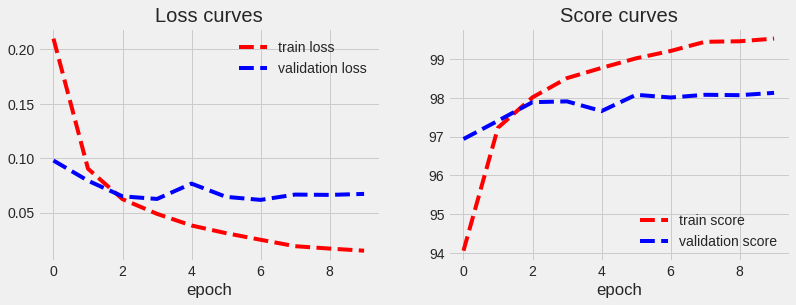

In [155]:
plot_learning_curve(history)

### Reporting

**Reports on fully connected network:**

Set parameters: 
- SGD with learning rate at 0.5
- Batch size of 64
- ReLU activation for hidden layers

|Epochs|Hidden Units|Validation Score (max)|Overfit|
|---|---|---|---|
10|0|82.7 (90)|~2.0
10|100|96.8 (97)|~1.5
10|[100,100]|97.2|~0.5
20|[100,100]|96.3 (97)|~2.0
20|[256,256]|97.7 |~1.5
10|[256,100]|97.2 (97.7) |~1.0

**Reports on different optimizers:**

Set parameters: 
- Hidden units [256,100]
- learning rate at 0.1
- Batch size of 64
- ReLU activation for hidden layers

|Optimizer|Epochs to achieve 95%|Epochs to achieve 98%|Validation Score Max after 10|
|---|---|---|---|
SGD|2|4|98.3
SGD with momentum at 0.9|2|-|96.0
SGD with momentum at 0.9 and Nesterov|2|-|96.0
RMSProp|-|-|-
Adadelta|2|7|98.0
Adam|-|-|-

**Reports on Batch Normalization:**

Set parameters: 
- Hidden units [256,100]
- SGD with learning rate at 0.1
- Batch size of 64
- ReLU activation for hidden layers

|Batchnorm|Epochs to achieve 95%|Epochs to achieve 98%|Validation Score Max after 10|
|---|---|---|---|
None|2|4|98.3
Before activation|1|4|98.1
After activation|1|6|98.1